# Example 3

## 3D case

**Content**

This notebook reproduces the first example of the paper. It consists of four main subheadings;

- Importing the *hcpinnseikonal* package functions
- Define the arguments for the input parameters
- Setup the medium and compute the data
- Training and inference

**Saving directory**

The notebook utilized [*wandb*](https://wandb.ai) for keeping track of the parameters and experiments. You can uncomment the *wandb* call to turn this feature off. Accordingly you need to specify the folder to save your experiment by changing the related *wandb* line inside the main function below.

## Import *hcpinnseikonal* package functions

In [1]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time

from argparse import ArgumentParser   
from scipy import interpolate

from hcpinnseikonal.utils import *
from hcpinnseikonal.nn import *
from hcpinnseikonal.model3d import *
from hcpinnseikonal.train3d import *
from hcpinnseikonal.plot import *
from hcpinnseikonal.arguments import *

args = parser.parse_args([])

args.use_wandb='n'

dict_args = vars(args)
print(dict_args)

# Change these lines for the wandb setup
if args.use_wandb=='y':
    wandb.init(project=args.project_name)
    wandb.run.log_code(".")
    wandb_dir = wandb.run.dir
else:
    args.save_folder='../saves/saves_fullnss2d'
    from pathlib import Path
    Path(args.save_folder).mkdir(parents=True, exist_ok=True)
    wandb_dir = args.save_folder

{'lateral_spacing': 0.01, 'vertical_spacing': 0.01, 'max_offset': 5.0, 'max_depth': 1.0, 'rec_spacing': 10, 'sou_spacing': 10, 'num_epochs': 250, 'num_neurons': 20, 'num_layers': 10, 'learning_rate': 0.001, 'model_type': 'seam', 'data_type': 'full', 'middle_shot': 'n', 'until_cmb': 'n', 'earth_scale': 'n', 'scale_factor': 10, 'reduce_after': 15, 'seed': 123, 'initialization': 'varianceScaling', 'plotting_factor': 1, 'rescale_plot': 'n', 'depth_shift': 'n', 'tau_multiplier': 3.0, 'initial_velocity': 4, 'zid_source': 5, 'zid_receiver': 0, 'explode_reflector': 'n', 'field_synthetic': 'n', 'v_multiplier': 3, 'activation': 'elu', 'num_points': 1.0, 'irregular_grid': 'n', 'xid_well': 5, 'last_vmultiplier': 5, 'v_units': 'unitless', 'well_depth': None, 'exp_function': 'n', 'exp_factor': 1.0, 'exclude_topo': 'n', 'exclude_well': 'n', 'exclude_source': 'n', 'loss_function': 'mse', 'station_factor': 1.0, 'event_factor': 1.0, 'checker_size': 5.0, 'tau_act': 'None', 'empty_middle': 'n', 'factoriza

## Define arguments

In [2]:
args.scale_factor=2 
args.until_cmb='y' 
args.num_epochs=1000
args.seed=1234 
args.learning_rate=5e-4
args.rescale_plot='n' 
args.initial_velocity=3 
args.zid_source=1 
args.zid_receiver=0 
args.data_type='full' 
args.irregular_grid='y' 
args.num_layers=12 
args.model_type='marmousi' 
args.v_multiplier=6 
args.factorization_type='additive' 
args.tau_act='tanh' 
args.tau_multiplier=1 
args.max_offset=4.9875
args.max_depth=1.5 #1.865625 
args.vertical_spacing=0.009375 
args.lateral_spacing=0.0375
args.num_neurons=24 
args.causality_factor=.5 

args.causality_weight='type_0' 
args.reduce_after=50 
args.field_synthetic='n' 
args.event_factor=0.9 
args.station_factor=0.2 
args.residual_network='y' 
args.empty_middle='n' 
args.regular_station='y' 
args.rec_spacing=10 
args.sou_spacing=20

args.sampling_rate=6

# args.num_layers=24
# args.num_neurons=48

dict_args=vars(args)
print(dict_args)

{'lateral_spacing': 0.0375, 'vertical_spacing': 0.009375, 'max_offset': 4.9875, 'max_depth': 1.5, 'rec_spacing': 10, 'sou_spacing': 20, 'num_epochs': 1000, 'num_neurons': 24, 'num_layers': 12, 'learning_rate': 0.0005, 'model_type': 'marmousi', 'data_type': 'full', 'middle_shot': 'n', 'until_cmb': 'y', 'earth_scale': 'n', 'scale_factor': 2, 'reduce_after': 50, 'seed': 1234, 'initialization': 'varianceScaling', 'plotting_factor': 1, 'rescale_plot': 'n', 'depth_shift': 'n', 'tau_multiplier': 1, 'initial_velocity': 3, 'zid_source': 1, 'zid_receiver': 0, 'explode_reflector': 'n', 'field_synthetic': 'n', 'v_multiplier': 6, 'activation': 'elu', 'num_points': 1.0, 'irregular_grid': 'y', 'xid_well': 5, 'last_vmultiplier': 5, 'v_units': 'unitless', 'well_depth': None, 'exp_function': 'n', 'exp_factor': 1.0, 'exclude_topo': 'n', 'exclude_well': 'n', 'exclude_source': 'n', 'loss_function': 'mse', 'station_factor': 0.2, 'event_factor': 0.9, 'checker_size': 5.0, 'tau_act': 'tanh', 'empty_middle': 'n

## Medium setup and data interpolation

Cuda installed! Running on GPU!
Device: cuda:0 Quadro RTX 8000
Loading time: 0.19 minutes


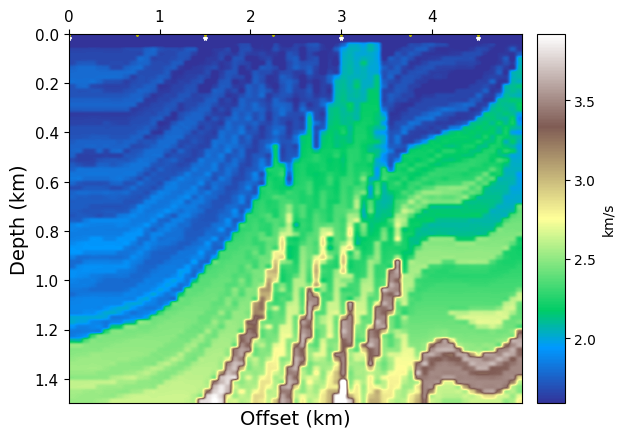

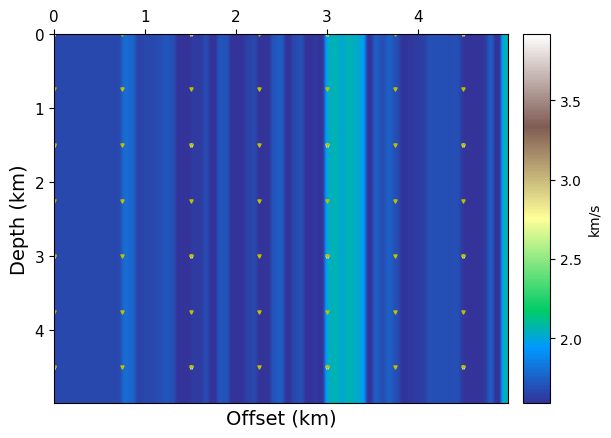

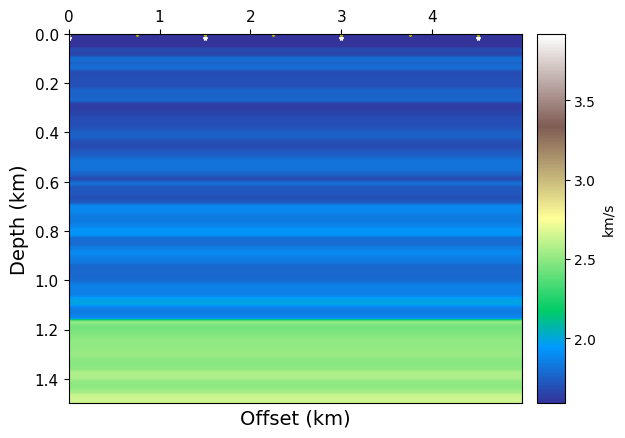

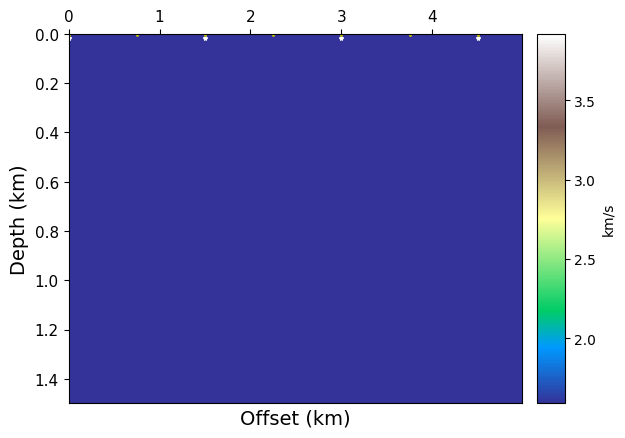

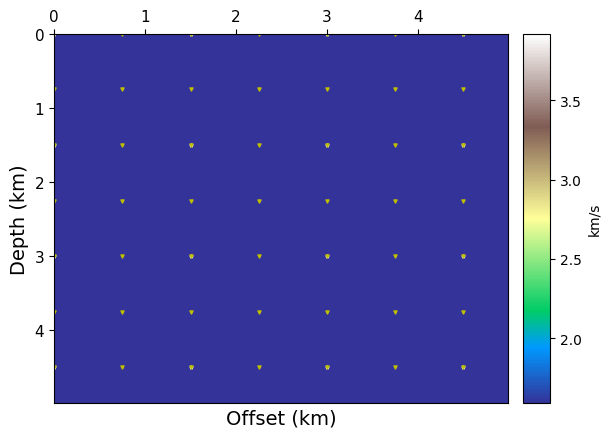

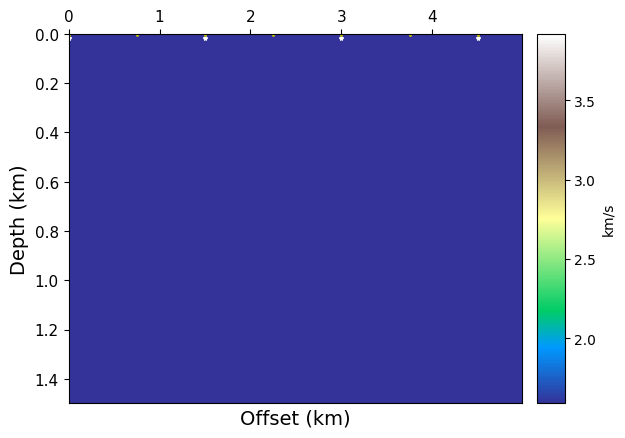

In [3]:
# Setup
if args.use_wandb=='y':
    wandb.config.update(args)

seed = args.seed

set_seed(seed)
device = set_device()

# Medium
data_type = args.data_type
deltar = args.rec_spacing
deltas = args.sou_spacing

# Computational model parameters
zmin = -0.1 if args.field_synthetic=='y' else 0; zmax = args.max_depth; #deltaz = args.vertical_spacing;
ymin = 0.; ymax = args.max_offset; #deltay = args.lateral_spacing;
xmin = 0.; xmax = args.max_offset; #deltax = args.lateral_spacing;
deltax, deltay, deltaz = args.sampling_rate*0.00625/2*4, args.sampling_rate*0.00625/2*4, args.sampling_rate*0.00625/2

if args.earth_scale=='y':
    earth_radi = 6371/args.scale_factor # Average in km
    xmin, xmax, deltax = earth_radi*xmin, earth_radi*xmax, earth_radi*deltax
    ymin, ymax, deltay = earth_radi*ymin, earth_radi*ymax, earth_radi*deltay
    zmin, zmax, deltaz = earth_radi*zmin, earth_radi*zmax, earth_radi*deltaz

# Creating grid, extending the velocity model, and prepare list of grid points for training (X_star)
z = np.arange(zmin,zmax,deltaz)
nz = z.size

y = np.arange(ymin,ymax,deltay)
ny = y.size

x = np.arange(xmin,xmax,deltax)
nx = x.size

Z,Y,X = np.meshgrid(z,y,x,indexing='ij')

# Number of training points
num_tr_pts = 4000 #int(args.num_points * nz * nx)

zeve, yeve, xeve = z[args.zid_source]*np.ones_like(x[::deltas]), y[::deltas], x[::deltas]
zsta, ysta, xsta = z[args.zid_receiver]*np.ones_like(x[::deltar]), y[::deltar], x[::deltar]
ztop, ytop, xtop = zmin*np.ones_like(x), np.copy(y), np.copy(x)

idx_all = np.arange(X.size).reshape(X.shape)

# Sources indices
id_sou = idx_all[args.zid_source, ::deltas, ::deltas].reshape(-1)

# Receivers indices
id_rec = idx_all[args.zid_receiver, ::deltar, ::deltar].reshape(-1)

# Keeping the number of shots fixed while centering the shots location
if args.middle_shot=='y':
    id_sou_left = x.shape[0]//2-len(id_sou_x)//2
    id_sou_x = np.array(range(id_sou_left, id_sou_left+len(id_sou_x)))
    id_sou_y = np.array(range(id_sou_left, id_sou_left+len(id_sou_y)))

if args.explode_reflector=='y':
    id_sou_x = np.arange(0, len(x), args.sou_spacing)
    id_sou_y = np.arange(0, len(y), args.sou_spacing)
    id_sou_z = np.ones_like(id_sou_x)*(len(z)-1)

if args.empty_middle=='y':
    id_sou, id_rec = (np.array(id_sou_x)<=(len(x)//2-50))|(np.array(id_sou_x)>=(len(x)//2+50)), (np.array(id_rec_x)<=(len(x)//2-50))|(np.array(id_rec_x)>=(len(x)//2+50))
    if args.field_synthetic=='n':
        id_sou_x = np.array(id_sou_x)[id_sou]
        id_sou_y = np.array(id_sou_y)[id_sou]
        id_sou_z = np.array(id_sou_z)[id_sou]
    id_rec_x = np.array(id_rec_x)[id_rec]
    id_rec_y = np.array(id_rec_y)[id_rec]
    id_rec_z = np.array(id_rec_z)[id_rec]

sz = Z.reshape(-1)[id_sou]
sy = Y.reshape(-1)[id_sou]
sx = X.reshape(-1)[id_sou]

Z,Y,X,SX = np.meshgrid(z,y,x,sx,indexing='ij')
_,_,_,SY = np.meshgrid(z,y,x,sy,indexing='ij')
_,_,_,SZ = np.meshgrid(z,y,x,sz,indexing='ij')
_,_,_,ID = np.meshgrid(z,y,x,np.arange(sx.size),indexing='ij')

if args.model_type=='marmousi':
    vel = np.fromfile('../data/marmousi.bin', np.float32).reshape(221, 601)
    x1 = np.linspace(0, 5, 601)
    z1 = np.linspace(0, 1, 221) 
    x2 = np.linspace(0.25, 5, len(x))
    z2 = np.linspace(0.09, 0.55, len(z)) 
    f = interpolate.interp2d(x1, z1, vel, kind='cubic')
    vel = f(x2, z2)
    # Augment a 3D velocity volume from 2D data
    vel3d = np.repeat(vel[:, np.newaxis, :], len(y), axis=1)
elif args.model_type=='seam':
    vel = np.load('/home/taufikmh/KAUST/spring_2022/constrained_eikonal/notebooks/PINNtomo/inputs/seam_model/vel_seam.npy')
    x1 = np.arange(0,1+0.01,0.01)
    z1 = np.arange(0,1+0.01,0.01)
    from scipy import interpolate
    f = interpolate.interp2d(x1, z1, vel, kind='cubic')
    vel = f(x, z)
    # Augment a 3D velocity volume from 2D data
    vel3d = np.repeat(vel[:, np.newaxis, :], len(y), axis=1)
elif args.model_type=='constant':
    vel = 4*np.ones((nz,nx))
elif args.model_type=='gradient':
    vel = 1 + 7*np.meshgrid(x,z)[1]
    vel3d = np.repeat(vel[:, np.newaxis, :], len(y), axis=1)
elif args.model_type=='arid':
    vel = np.fromfile('../data/seam_arid', np.float32).reshape(400,400,600)/1000
    vel3d = np.moveaxis(vel[::args.sampling_rate,::args.sampling_rate,::args.sampling_rate], -1, 0)[20:,:,:]
    
# Extending the velocity model in thirs dimension byy repeatin the array
velmodel = np.repeat(vel3d[...,np.newaxis], sx.size,axis=2)

if args.depth_shift=='y':
    zmin, zmax, z, sz, Z, SZ = zmin+5, zmax+5, z+5, sz+5, Z+5, SZ+5

X_star = [Z.reshape(-1,1), Y.reshape(-1,1), X.reshape(-1,1), SY.reshape(-1,1), SX.reshape(-1,1)] # Grid points for prediction 

# Numerical traveltime
T_data3d = numerical_traveltime3d(vel3d, len(x), len(y), len(z), len(id_sou), 
                                  xmin, ymin, zmin, deltax, deltay, deltaz, 
                                  [np.where(x==X[:,:,:,0].reshape(-1)[id_sou[i]])[0][0] for i in range(len(id_sou))], 
                                  [np.where(y==Y[:,:,:,0].reshape(-1)[id_sou[i]])[0][0] for i in range(len(id_sou))], 
                                  [np.where(z==Z[:,:,:,0].reshape(-1)[id_sou[i]])[0][0] for i in range(len(id_sou))])

# ZX plane after
plot_section(vel3d[:,10,:], 'v_true_zx.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=X[:,:,:,0].reshape(-1)[id_sou],sz=Z[:,:,:,0].reshape(-1)[id_sou],rx=X[:,:,:,0].reshape(-1)[id_rec],rz=Z[:,:,:,0].reshape(-1)[id_rec])

# XY plane
plot_section(vel3d[5,:,:], 'v_true_xy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X[:,:,:,0].reshape(-1)[id_sou],sz=Y[:,:,:,0].reshape(-1)[id_sou],rx=X[:,:,:,0].reshape(-1)[id_rec],rz=Y[:,:,:,0].reshape(-1)[id_rec])

# ZY plane
plot_section(vel3d[:,:,10], 'v_true_zy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y[:,:,:,0].reshape(-1)[id_sou],sz=Z[:,:,:,0].reshape(-1)[id_sou],rx=Y[:,:,:,0].reshape(-1)[id_rec],rz=Z[:,:,:,0].reshape(-1)[id_rec])

# Plots
if args.model_type=='checkerboard':
    plot_section((6 + 6.5217391304347826*Z[:,:,0])/args.scale_factor, "v_back.pdf", 
                 save_dir=wandb_dir, aspect='auto',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z])
    plot_section(velpert[:,:,0]/args.scale_factor, "v_pert.pdf", 
                 save_dir=wandb_dir, aspect='auto',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z])

# Interpolation
Td_nn = np.zeros_like(T_data3d)
taudx_nn = np.zeros_like(T_data3d)

Ti_data = np.zeros((len(id_rec)*len(id_sou)))
xri = np.tile(X.reshape(-1)[id_rec], len(id_sou))
yri = np.tile(Y.reshape(-1)[id_rec], len(id_sou))
zri = np.tile(Z.reshape(-1)[id_rec], len(id_sou))

xsi = np.repeat(X.reshape(-1)[id_sou], len(id_rec))
ysi = np.repeat(Y.reshape(-1)[id_sou], len(id_rec))
zsi = np.repeat(Z.reshape(-1)[id_sou], len(id_rec))

for i in range(len(id_sou)):
    Ti_data[i*len(id_rec):(i+1)*len(id_rec)] = T_data3d[:,:,:,i].reshape(-1)[id_rec]
    
rand_idx = np.random.permutation(np.arange(len(Ti_data)))

X_ori = np.vstack((xri, yri, zri, xsi, ysi, zsi)).T
y_ori = Ti_data

X_all = X_ori[rand_idx,:]
y_all = y_ori[rand_idx]

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

X_ori = torch.from_numpy(X_ori).float()

all_dataset = torch.utils.data.TensorDataset(X_all, y_all)

# Use Pytorch's functionality to load data in batches. Here we use full-batch training again.
all_loader = torch.utils.data.DataLoader(all_dataset, batch_size=16, shuffle=True)

if data_type=='nn':
    torch.manual_seed(8888)
    model = FullyConnectedNetwork(6, 1, n_hidden=[args.data_neurons]*args.data_layers, act='elu')
    # optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) # best
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(5*args.reduce_after), verbose=True)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(4*args.reduce_after), verbose=True)
    criterion = torch.nn.MSELoss()
    model.train()
    loss_data = []
    for epoch in range(int(5e3)):
        total_loss = 0.
        model.train()
        loss = 0
        for x_i, y_i in all_loader:
            optimizer.zero_grad()
            yest = model(x_i).view(-1)
            loss = criterion(yest, y_i)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 50 == 0 and epoch > 0:
            print(f'Epoch: {epoch}, Loss: {total_loss / X_all[:,0].detach().numpy().size}')
        mean_loss = total_loss / X_all[:,0].detach().numpy().size
        # wandb.log({"data_loss": mean_loss})
        scheduler.step(mean_loss)
        loss_data.append(mean_loss)

    Td_nn = np.zeros_like(T_data3d)
    
    if args.field_synthetic=='y':
        X_all = [np.tile(x[id_top_x], len(sx)), np.tile(z[id_top_z], len(sz)), 
                 np.repeat(x[id_sou_x], len(x[id_top_x])), 
                 np.repeat(z[id_sou_z], len(z[id_top_z]))]
    else:
        X_all = [np.tile(x, len(sx)), 
                 np.tile(y, len(sy)),
                 np.tile(z[args.zid_receiver]*np.ones_like(x), len(sz)), 
                 np.repeat(x[id_sou_x], len(x)), 
                 np.repeat(y[id_sou_y], len(y)), 
                 np.repeat(z[id_sou_z], len(z))]

    model.eval()
    Td_pred = model(torch.FloatTensor(X_all).T)

    for i in range(len(id_sou)):
        Td_nn[:,:,:,i] = Td_pred[i*len(x):(i+1)*len(x)].detach().numpy().reshape(-1)

    # Convergence history plot for verification
    fig = plt.figure()
    ax = plt.axes()
    ax.semilogy(loss_data)

    ax.set_xlabel('Epochs',fontsize=14)

    plt.xticks(fontsize=11)

    ax.set_ylabel('Loss',fontsize=14)
    plt.yticks(fontsize=11);
    plt.grid()
    plt.savefig(os.path.join(wandb_dir, "data_loss.pdf"), format='pdf', bbox_inches="tight")

    # Save model
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_data
    }, wandb_dir+'/saved_data_model')

# Analytical solution for the known traveltime part
if args.depth_shift=='y':
    vs = args.initial_velocity #velmodel[np.round((SZ-5)/deltaz).astype(int),np.round(SX/deltax).astype(int),0]
else:
    vs = vel3d[np.round(SZ/deltaz).astype(int),np.round(SY/deltay).astype(int),np.round(SX/deltax).astype(int)]

T0 = np.sqrt((Z-SZ)**2 + (Y-SY)**2 + (X-SX)**2)/vs;
px0 = np.divide(X-SX, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)
py0 = np.divide(Y-SY, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)
pz0 = np.divide(Z-SZ, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)

if args.field_synthetic=='y':
    xf = np.arange(xmin,xmax+0.1*deltax,0.1*deltax)
    zf = np.arange(zmin,zmax+0.1*deltaz,0.1*deltaz)
    T_topo = np.zeros((len(zf), len(xf), len(id_sou_x)))
    for i in range(len(id_sou_x)):
        f = interpolate.interp2d(x, z, T_data3d[:,:,i], kind='cubic')
        T_topo[:,:,i] = f(xf, zf)
    id_top_x = []
    id_top_z = []

    for h in range(len(xtop)):

        for i in range(len(x)):
            if np.abs(xtop[h]-x[i])<1e-2:
                id_top_x.append(i)

        for j in range(len(z)):    
            if np.abs(ztop[h]-z[j])<5e-3:
                id_top_z.append(j)

    taud_topo = np.divide(T_data3d, T0, where=T0!=0)[id_top_z, id_top_x, :]
    T_topo = T_data[id_top_z, id_top_x, :]

    taud_topo = np.repeat(taud_topo, nz).reshape(nx,len(id_sou_x),nz).swapaxes(1,2).swapaxes(0,1)
    T_topo = np.repeat(T_topo, nz).reshape(nx,len(id_sou_x),nz).swapaxes(1,2).swapaxes(0,1)

Td_hc = np.zeros_like(T0)
T0_hc = np.zeros_like(T0)
taud_hc = np.zeros_like(T0)
taudx_hc = np.zeros_like(T0)
taudy_hc = np.zeros_like(T0)

for i in range(len(id_sou)):
    T0_hc[:,:,:,i] = np.moveaxis(np.tile(T0.reshape(X.shape)[args.zid_receiver,:,:,i], nz).reshape(ny,nz,nx), 1, 0)
    # np.tile(T0[args.zid_receiver,:,:,i], nz).reshape(nz,ny,nx)

    # Numerical
    if data_type=='full':
        Td_hc[:,:,:,i] = np.moveaxis(np.tile(T_data3d[args.zid_receiver,:,:,i], nz).reshape(ny,nz,nx), 1, 0)
    # np.tile(T_data3d[args.zid_receiver,:,:,i], nz).reshape(nz,ny,nx)

    # NN-based interpolation
    elif data_type=='nn':
        Td_hc[:,:,:,i] = Td_nn[:,:,:,i].reshape(nz,ny,nx)

    if args.factorization_type=='multiplicative':   
        taud_hc[:,:,:,i] = np.divide(Td_hc[:,:,:,i], T0_hc[:,:,:,i], out=np.ones_like(T0_hc[:,:,:,i]),
                                   where=T0_hc[:,:,:,i]!=0)
    else:
        taud_hc[:,:,:,i] = Td_hc[:,:,:,i] - T0_hc[:,:,:,i]

    # Numerical
    if data_type=='full':
        taudy_hc[:,:,:,i] = np.gradient(taud_hc.reshape(X.shape)[:,:,:,i], deltay, axis=1)
        taudx_hc[:,:,:,i] = np.gradient(taud_hc.reshape(X.shape)[:,:,:,i], deltax, axis=2)

    # NN-based interpolation
    elif data_type=='nn':
        taudy_hc[:,:,:,i] = np.gradient(taud_hc.reshape(X.shape)[:,:,:,i], deltay, axis=1)        
        taudx_hc[:,:,:,i] = np.gradient(taud_hc.reshape(X.shape)[:,:,:,i], deltax, axis=2)

if args.field_synthetic=='y':

    NAN = np.ones_like(X)
    for i in range(z.shape[0]):
        for j in range(x.shape[0]):
            if z[i] < Z[id_top_z, id_top_x, 0][j]:
                NAN[i,j,:] = float("Nan")

# Locate source boolean
import time
start_time = time.time()

sids = id_sou

# Locate source boolean
isource = np.ones_like(Z).astype(bool)

# Locate source boolean
for i in range(isource.shape[-1]):
    isource[:,:,:,i].reshape(-1,)[id_sou[i]] = False
    
isource = isource.reshape(-1)

velmodel = vel3d.reshape(-1,1)
px0 = px0.reshape(-1,1)
py0 = py0.reshape(-1,1)
pz0 = pz0.reshape(-1,1)
T0 = T0.reshape(-1,1)
T_data = T_data3d.reshape(-1,1)
taud = taud_hc.reshape(-1,1)

if args.factorization_type=='multiplicative':
    taud[~isource] = 1.    
taudx = taudx_hc.reshape(-1,1)
taudy = taudy_hc.reshape(-1,1)
index = ID.reshape(-1,1)

perm_id = np.random.permutation(X.size-sx.size)

input_wsrc = [X, Y, Z, SX+len(id_sou), SY+len(id_sou), SZ+len(id_sou), taud, taudx, taudy, T0, px0, py0, pz0, index]
input_wosrc = [i.ravel()[isource.reshape(-1)][perm_id] for i in input_wsrc]
if args.field_synthetic=='y':
    input_wonan = [i.ravel()[~np.isnan(NAN.ravel()[isource.reshape(-1)][perm_id])] for i in input_wosrc]

# Network
lay = 'linear'
ini = args.initialization
bias = 0.2
mean = 0.01
std = 0.05
opttype = 'adam'
lr = args.learning_rate

torch.manual_seed(seed)
if args.residual_network=='n':
    tau_model = FullyConnectedNetwork(6, 1, [args.num_neurons]*args.num_layers, last_act=args.tau_act, act=args.activation, lay=lay, last_multiplier=args.tau_multiplier)
else:
    tau_model = ResidualNetwork(6, 1, num_neurons=args.num_neurons, num_layers=args.num_layers, act=args.activation, lay=lay, last_multiplier=args.tau_multiplier)
tau_model.to(device)

torch.manual_seed(seed)
if args.residual_network=='n':
    v_model = FullyConnectedNetwork(3, 1, [args.num_neurons//2]*args.num_layers, act=args.activation, lay=lay, last_act='relu', last_multiplier=args.v_multiplier)
else:
    v_model = ResidualNetwork(3, 1, num_neurons=args.num_neurons//2, act='relu', last_act='relu', num_layers=args.num_layers, lay=lay, last_multiplier=args.v_multiplier)
v_model.to(device)
v_model.apply(lambda m: init_weights(m, init_type=ini, bias=bias, mean=mean, std=std))

perc = args.num_points

if args.irregular_grid=='y':
    npoints = int(X.size * perc)
    ipermute = np.random.permutation(np.arange(X.size))[:npoints]
else:
    ipermute = None

# Compute traveltime with randomly initialized network
pde_loader, ic = create_dataloader3d([i.ravel() for i in input_wsrc], sx, sy, sz,
                                   shuffle=False, batch_size=2048, fast_loader=True, perm_id=ipermute)

if args.exp_function=='y':
    rec_op = (1-np.exp((Z.reshape(X.shape)-z[args.zid_receiver])**args.exp_factor))
else:
    rec_op = Z.reshape(X.shape)

v_init = evaluate_velocity3d(v_model, pde_loader, X.size, batch_size=2048, device=device)
tau_init = evaluate_tau3d(tau_model, pde_loader, X.size, batch_size=2048, device=device)

elapsed = time.time() - start_time
print('Loading time: %.2f minutes' %(elapsed/60.))

# Optimizer
if opttype == 'adam':
    optimizer = torch.optim.Adam(list(tau_model.parameters()) + list(v_model.parameters()), lr=lr, betas=(0.9, 0.999), eps=1e-5)
elif opttype == 'lbfgs':
    optimizer = torch.optim.LBFGS(list(tau_model.parameters()) + list(v_model.parameters()), line_search_fn="strong_wolfe")

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=args.reduce_after, verbose=True)

v_init = v_init.detach().cpu().numpy().reshape(X.shape)

# ZX plane after
plot_section(v_init.reshape(X.shape)[:,10,:,0], 'v_init_zx.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=X[:,:,:,0].reshape(-1)[id_sou],sz=Z[:,:,:,0].reshape(-1)[id_sou],rx=X[:,:,:,0].reshape(-1)[id_rec],rz=Z[:,:,:,0].reshape(-1)[id_rec])

# XY plane
plot_section(v_init.reshape(X.shape)[5,:,:,0], 'v_init_xy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X[:,:,:,0].reshape(-1)[id_sou],sz=Y[:,:,:,0].reshape(-1)[id_sou],rx=X[:,:,:,0].reshape(-1)[id_rec],rz=Y[:,:,:,0].reshape(-1)[id_rec])

# ZY plane
plot_section(v_init.reshape(X.shape)[:,:,10,0], 'v_init_zy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y[:,:,:,0].reshape(-1)[id_sou],sz=Z[:,:,:,0].reshape(-1)[id_sou],rx=Y[:,:,:,0].reshape(-1)[id_rec],rz=Z[:,:,:,0].reshape(-1)[id_rec])

## Training and Inference

In [4]:
# Training
import time
start_time = time.time()
if args.field_synthetic=='y':
    loss_history = \
        training_loop3d(
            input_wonan, sx, sy, sz,
            tau_model, v_model, optimizer, args.num_epochs, 
            batch_size=Z.size//2000, device=device, scheduler=scheduler,
            fast_loader=True, args=dict_args
    ) 
else:
    loss_history = \
        training_loop3d(
            input_wosrc, sx, sy, sz,
            tau_model, v_model, optimizer, args.num_epochs, 
            batch_size=Z.size//2000, device=device, scheduler=scheduler, 
            fast_loader=True, args=dict_args
    )
elapsed = time.time() - start_time
print('Training time: %.2f minutes' %(elapsed/60.))

# Convergence history plot for verification
fig = plt.figure()
ax = plt.axes()
ax.semilogy(loss_history)
ax.set_xlabel('Epochs',fontsize=14)
plt.xticks(fontsize=11)
ax.set_ylabel('Loss',fontsize=14)
plt.yticks(fontsize=11);212
plt.grid()
plt.savefig(os.path.join(wandb_dir, "loss.pdf"), format='pdf', bbox_inches="tight")

# Save model
torch.save({
        'tau_model_state_dict': tau_model.state_dict(),
        'v_model_state_dict': v_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_history
}, wandb_dir+'/saved_model')

# To load
checkpoint = torch.load(wandb_dir+'/saved_model')
tau_model.load_state_dict(checkpoint['tau_model_state_dict'])
v_model.load_state_dict(checkpoint['v_model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Prediction
pde_loader, ic = create_dataloader3d([i.ravel() for i in input_wsrc], sx, sy, sz,
                                   shuffle=False, batch_size=2048, fast_loader=True, perm_id=ipermute)
v_pred = evaluate_velocity3d(v_model, pde_loader, X.size, batch_size=2048, device=device)

tau_pred = evaluate_tau3d(tau_model, pde_loader, X.size, batch_size=2048, device=device)

v_pred = v_pred.detach().cpu().numpy()
tau_pred = tau_pred.detach().cpu().numpy()

# ZX plane after
plot_section(v_pred.reshape(X.shape)[:,10,:,i], 'v_pred_zx.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=X[:,:,:,i].reshape(-1)[id_sou],sz=Z[:,:,:,i].reshape(-1)[id_sou],rx=X[:,:,:,i].reshape(-1)[id_rec],rz=Z[:,:,:,i].reshape(-1)[id_rec])

# XY plane
plot_section(v_pred.reshape(X.shape)[5,:,:,i], 'v_pred_xy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X[:,:,:,i].reshape(-1)[id_sou],sz=Y[:,:,:,i].reshape(-1)[id_sou],rx=X[:,:,:,i].reshape(-1)[id_rec],rz=Y[:,:,:,i].reshape(-1)[id_rec])

# ZY plane
plot_section(v_pred.reshape(X.shape)[:,:,10,i], 'v_pred_zy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y[:,:,:,i].reshape(-1)[id_sou],sz=Z[:,:,:,i].reshape(-1)[id_sou],rx=Y[:,:,:,i].reshape(-1)[id_rec],rz=Z[:,:,:,i].reshape(-1)[id_rec])

print(y[30])
for i in range(len(x)):
    if i%10==0:
        plot_trace(v_init[:,:,30,0], vel3d[:,:,30], v_pred.reshape(X.shape)[:,:,30,0], i, x, z, 
                   fig_name='trace_x_'+str(round(x[i], 2))+'.pdf', save_dir=wandb_dir)
        
print(x[20])
for i in range(len(y)):
    if i%10==0:
        plot_trace(v_init[:,20,:,0], vel3d[:,20,:], v_pred.reshape(X.shape)[:,20,:,0], i, x, z, 
                   fig_name='trace_y_'+str(round(y[i], 2))+'.pdf', save_dir=wandb_dir)

Epoch 0, Loss 0.0085221
Epoch 3, Loss 0.0009013
Epoch 6, Loss 0.0004857
Epoch 9, Loss 0.0003541
Epoch 12, Loss 0.0002835
Epoch 15, Loss 0.0002379
Epoch 18, Loss 0.0002054
Epoch 21, Loss 0.0001796
Epoch 24, Loss 0.0001633
Epoch 27, Loss 0.0001487
Epoch 30, Loss 0.0001383
Epoch 33, Loss 0.0001288
Epoch 36, Loss 0.0001204
Epoch 39, Loss 0.0001150
Epoch 42, Loss 0.0001104
Epoch 45, Loss 0.0001031
Epoch 48, Loss 0.0001005
Epoch 51, Loss 0.0000973
Epoch 54, Loss 0.0000933
Epoch 57, Loss 0.0000906
Epoch 60, Loss 0.0000868
Epoch 63, Loss 0.0000847
Epoch 66, Loss 0.0000817
Epoch 69, Loss 0.0000812


KeyboardInterrupt: 